<a href="https://colab.research.google.com/github/KarthiK2601/ViT/blob/main/Fashion_MNIST_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import torch
from torch import nn
from torch.nn import Transformer
import torchvision.transforms as transforms
import torchvision.datasets as datasets

class PatchEmbedding(nn.Module):
    def __init__(self, patch_size, in_channels, embed_dim):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, E, H, W)
        x = x.flatten(2)  # (B, E, H*W)
        x = x.transpose(1, 2)  # (B, H*W, E)
        return x

class ViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, channels, embed_dim, num_heads, num_layers, hidden_dim):
        super().__init__()

        self.patch_embedding = PatchEmbedding(patch_size, channels, embed_dim)

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        num_patches = (image_size // patch_size) ** 2
        self.position_embedding = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embedding(x)

        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        x = x + self.position_embedding

        x = self.transformer(x)

        x = x.mean(dim=1)
        x = self.classifier(x)

        return x



Epoch [1/10], Step [100/938], Loss: 1.3404
Epoch [1/10], Step [200/938], Loss: 1.0165
Epoch [1/10], Step [300/938], Loss: 0.6590
Epoch [1/10], Step [400/938], Loss: 0.7418
Epoch [1/10], Step [500/938], Loss: 0.6265
Epoch [1/10], Step [600/938], Loss: 0.4619
Epoch [1/10], Step [700/938], Loss: 0.6853
Epoch [1/10], Step [800/938], Loss: 0.6745
Epoch [1/10], Step [900/938], Loss: 0.6796
Epoch [2/10], Step [100/938], Loss: 0.5933
Epoch [2/10], Step [200/938], Loss: 0.6942
Epoch [2/10], Step [300/938], Loss: 0.7666
Epoch [2/10], Step [400/938], Loss: 0.2972
Epoch [2/10], Step [500/938], Loss: 0.4857
Epoch [2/10], Step [600/938], Loss: 0.4194
Epoch [2/10], Step [700/938], Loss: 0.5848
Epoch [2/10], Step [800/938], Loss: 0.3574
Epoch [2/10], Step [900/938], Loss: 0.3728
Epoch [3/10], Step [100/938], Loss: 0.3550
Epoch [3/10], Step [200/938], Loss: 0.4662
Epoch [3/10], Step [300/938], Loss: 0.5244
Epoch [3/10], Step [400/938], Loss: 0.6342
Epoch [3/10], Step [500/938], Loss: 0.4637
Epoch [3/10

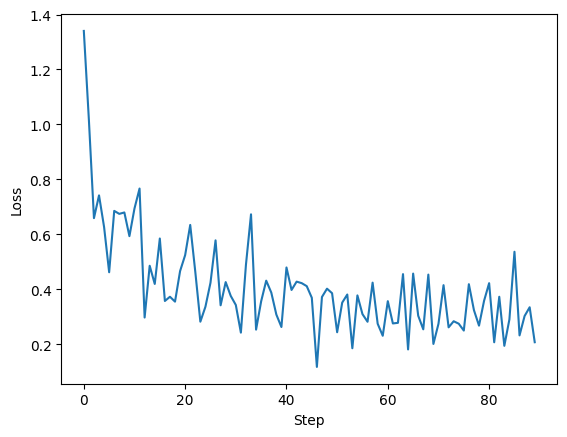

In [6]:
import torch
from torch import nn, optim
from torch.nn import Transformer
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

# Prepare the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Define the model
model = ViT(image_size=28, patch_size=7, num_classes=10, channels=1, embed_dim=64, num_heads=8, num_layers=1, hidden_dim=512)
model.to('cpu')

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
losses = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to('cpu')
        labels = labels.to('cpu')

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
            losses.append(loss.item())

# Plot the loss curve
plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()


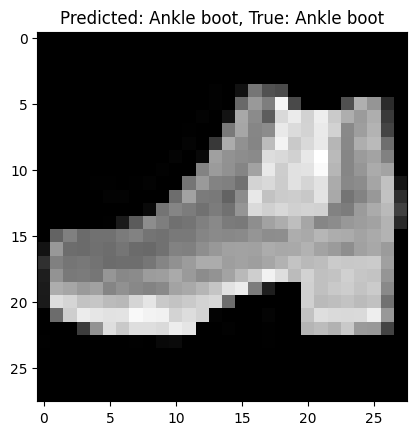

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Map of the index to the class name
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Set the model in evaluation mode
model.eval()

# Choose a random test image
image_index = np.random.randint(len(test_dataset))
image, true_label = test_dataset[image_index]

# Un-normalize the image
image_unnormalized = image * 0.5 + 0.5

# Make a prediction
with torch.no_grad():
    image = image.unsqueeze(0)  # add a batch dimension
    image = image.to('cpu')  # use the same device as your model
    output = model(image)
prediction = output.argmax(dim=1).item()

# Display the image and the prediction
plt.imshow(image_unnormalized.squeeze(), cmap='gray')
plt.title(f'Predicted: {class_names[prediction]}, True: {class_names[true_label]}')
plt.show()
